# CS672 Deep Learning Project #3

Aayushi Verma

The task is to classify the [Kaggle Cats and Dogs image dataset](https://www.kaggle.com/c/dogs-vs-cats/data) using two approaches: implementing Tensorflow code, and implementing PyTorch code. We will also implement a pre-trained image classifier to compare the two approaches.

We start by importing the relevant packages and data.

In [64]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models
from torch.utils.data import random_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import h5py
from torchvision.models import inception_v3

The original Cats & Dogs dataset has 12,500 images per class, i.e. a total of 25,000 images. I initially used Google Colab to read in the images from Google Drive, hoping that would take the load off my laptop, but Colab's RAM ran out. I then switched to my local computer environment, but my computer (2019 MacBook Pro) was having a lot of trouble reading, processing, building and evaluating the models, so I instead just used a smaller subset of 250 images per class, for a total of 500 images, for the purposes of this assignment.

In [2]:
# Specify the path to the directory containing your images
folder_path = '/Users/av15397n/Documents/GitHub/kagglecatsanddogs_5340/PetImages/Subset/'

# List all subdirectories in the PetImages directory
subfolders = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]

In [3]:
# Initialize lists to store images and labels
images = []
labels = []

# Iterate through subfolders
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)

    # List all files in the subfolder excluding .DS_Store
    image_files = [f for f in os.listdir(subfolder_path) if f != '.DS_Store' and os.path.isfile(os.path.join(subfolder_path, f))]

    # Read each image using OpenCV and assign the label
    for image_file in image_files:
        image_path = os.path.join(subfolder_path, image_file)
        image = cv2.imread(image_path)
        if image is not None:
            # Optionally, you can perform additional processing on each image if needed
            # For example, resizing, normalization, etc.
            images.append(image)
            labels.append(subfolder.lower())  # Assign label based on subfolder name
        else:
            print(f"Warning: Unable to load image {image_file}")


In [4]:
# Specify the target size
target_size = (224, 224)

# Resize images to the target size
resized_images = [cv2.resize(img, target_size) for img in images]

# Convert the list of resized images to a NumPy array
images = np.array(resized_images)

# Now, you can check the shape
print(images.shape)

(500, 224, 224, 3)


In [5]:
# Convert images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Convert labels to numerical encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

# Convert numerical labels to one-hot encoding
num_classes = len(label_encoder.classes_)
onehot_encoded = tf.keras.utils.to_categorical(integer_encoded, num_classes)

# Convert NumPy arrays to TensorFlow tensors
train_images = tf.convert_to_tensor(images)
train_labels = tf.convert_to_tensor(onehot_encoded)

# Print the shapes to identify any inconsistencies
print("Shapes:")
print("Train Images:", train_images.shape)
print("Train Labels:", train_labels.shape)

Shapes:
Train Images: (500, 224, 224, 3)
Train Labels: (500, 2)


In [6]:
# Assuming you have loaded your images and labels into variables train_images and train_labels
# Convert images and labels to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Convert one-hot encoded labels to binary format
train_labels = np.argmax(train_labels, axis=1)  # Fix this line

# Split the data into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

In [7]:
train_labels.shape

(400,)

## Part 1: Implementing Tensorflow Code

### 1.1 Keras Sequential Model

In [8]:
# Build the model using the Sequential API
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [9]:
# Train the model
tf_base_history = model.fit(train_images, train_labels, epochs=10, batch_size=100, validation_data=(test_images, test_labels))

Epoch 1/10
4/4 [==============================] - 11s 3s/step - loss: 853.0803 - accuracy: 0.4800 - val_loss: 53.4655 - val_accuracy: 0.5400
Epoch 2/10
4/4 [==============================] - 10s 3s/step - loss: 22.4101 - accuracy: 0.4850 - val_loss: 5.0637 - val_accuracy: 0.4600
Epoch 3/10
4/4 [==============================] - 10s 3s/step - loss: 2.0731 - accuracy: 0.5200 - val_loss: 0.7161 - val_accuracy: 0.4500
Epoch 4/10
4/4 [==============================] - 10s 2s/step - loss: 0.7833 - accuracy: 0.5025 - val_loss: 0.6939 - val_accuracy: 0.4700
Epoch 5/10
4/4 [==============================] - 10s 3s/step - loss: 0.6926 - accuracy: 0.5175 - val_loss: 0.6932 - val_accuracy: 0.4600
Epoch 6/10
4/4 [==============================] - 10s 3s/step - loss: 0.6860 - accuracy: 0.5100 - val_loss: 0.6651 - val_accuracy: 0.4600
Epoch 7/10
4/4 [==============================] - 10s 3s/step - loss: 0.6767 - accuracy: 0.5100 - val_loss: 0.6784 - val_accuracy: 0.4600
Epoch 8/10
4/4 [==============

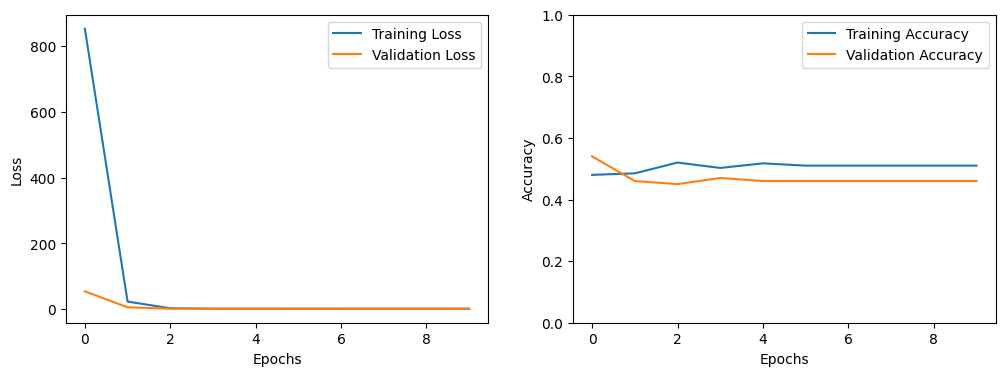

In [10]:
# Plot loss vs epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(tf_base_history.history['loss'], label='Training Loss')
plt.plot(tf_base_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy vs epoch
plt.subplot(1, 2, 2)
plt.plot(tf_base_history.history['accuracy'], label='Training Accuracy')
plt.plot(tf_base_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.show()

### 1.2 Pre-Trained InceptionV3 Model in Tensorflow/Keras Framework

For our pre-trained model, we will use the [InceptionV3 model](https://www.kaggle.com/datasets/madmaxliu/inceptionv3/).

In [11]:
# Rebuild the InceptionV3 model
base_model = InceptionV3(weights=None, include_top=False, input_shape=(224, 224, 3))

# Load the weights from the local file
model_path = '/Users/av15397n/Documents/GitHub/kagglecatsanddogs_5340/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model.load_weights(model_path)

# Freeze the weights of the InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# Create your custom model on top of the InceptionV3 base
model = tf.keras.models.Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6553728   
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 28356641 (108.17 MB)
Trainable params: 6553857 (25.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [12]:
# Assuming you have train_images, train_labels, test_images, test_labels
# Callbacks
tf_inception_history = History()
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Train the model with callbacks for plotting loss and accuracy
tf_inception_history = model.fit(
    train_images, train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(test_images, test_labels),
    callbacks=[tf_inception_history, checkpoint, early_stopping]
)

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 126.9906 - accuracy: 0.5075

/Users/av15397n/Documents/GitHub/CS672-Deep-Learning/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 15s 898ms/step - loss: 126.9906 - accuracy: 0.5075 - val_loss: 39.3978 - val_accuracy: 0.5400
Epoch 2/10
13/13 [==============================] - 11s 880ms/step - loss: 23.9912 - accuracy: 0.6350 - val_loss: 23.7214 - val_accuracy: 0.5300
Epoch 3/10
13/13 [==============================] - 12s 918ms/step - loss: 13.4245 - accuracy: 0.6875 - val_loss: 29.0010 - val_accuracy: 0.5700
Epoch 4/10
13/13 [==============================] - 12s 945ms/step - loss: 14.8867 - accuracy: 0.6950 - val_loss: 34.3811 - val_accuracy: 0.5000
Epoch 5/10
13/13 [==============================] - 13s 1s/step - loss: 10.6654 - accuracy: 0.6950 - val_loss: 22.5454 - val_accuracy: 0.5500
Epoch 6/10
13/13 [==============================] - 12s 954ms/step - loss: 2.9056 - accuracy: 0.8625 - val_loss: 19.8986 - val_accuracy: 0.4600
Epoch 7/10
13/13 [==============================] - 12s 955ms/step - loss: 1.8975 - accuracy: 0.9050 - val_loss: 16.5080 - val_accuracy: 0.5700


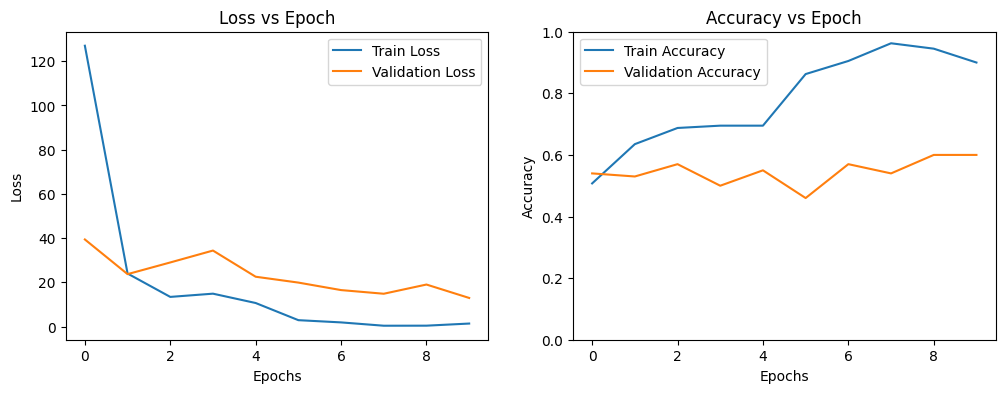

In [13]:
# Plotting loss vs accuracy, loss vs epoch, accuracy vs epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(tf_inception_history.history['loss'], label='Train Loss')
plt.plot(tf_inception_history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tf_inception_history.history['accuracy'], label='Train Accuracy')
plt.plot(tf_inception_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.show()

## Part 2: Implementing PyTorch Code

### 2.1 PyTorch Model

In [14]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the entire dataset
full_dataset = datasets.ImageFolder(root=folder_path, transform=transform)

In [15]:
# Split the dataset into train and test sets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [16]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [17]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
# Define a simple neural network architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Create an instance of the model
model = SimpleNN()

In [19]:
# Define a loss function and an optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SimpleNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [21]:
# Training loop
num_epochs = 10
pt_base_train_losses = []
pt_base_test_losses = []
pt_base_test_accuracies = []
pt_base_epochs = []  # Add this line to create the 'epochs' variable

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0  # Initialize epoch training loss
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()  # Accumulate batch loss

    # Average training loss over all batches in the epoch
    epoch_train_loss /= len(train_loader)
    pt_base_train_losses.append(epoch_train_loss)

    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        correct_predictions = 0
        total_samples = 0
        test_loss = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            test_loss += criterion(predictions, labels.unsqueeze(1).float()).item()
            predicted_classes = (predictions > 0.5).float()
            correct_predictions += (predicted_classes == labels.unsqueeze(1)).sum().item()
            total_samples += labels.size(0)

        test_accuracy = correct_predictions / total_samples
        pt_base_test_losses.append(test_loss / len(test_loader))
        pt_base_test_accuracies.append(test_accuracy)
        pt_base_epochs.append(epoch + 1)  # Add the current epoch to the 'epochs' list
        print(f'Epoch [{epoch + 1}/{num_epochs}], Test Accuracy: {test_accuracy:.4f}')

Epoch [1/10], Test Accuracy: 0.5200
Epoch [2/10], Test Accuracy: 0.5100
Epoch [3/10], Test Accuracy: 0.4800
Epoch [4/10], Test Accuracy: 0.5400
Epoch [5/10], Test Accuracy: 0.4900
Epoch [6/10], Test Accuracy: 0.5100
Epoch [7/10], Test Accuracy: 0.5900
Epoch [8/10], Test Accuracy: 0.5000
Epoch [9/10], Test Accuracy: 0.5400
Epoch [10/10], Test Accuracy: 0.5400


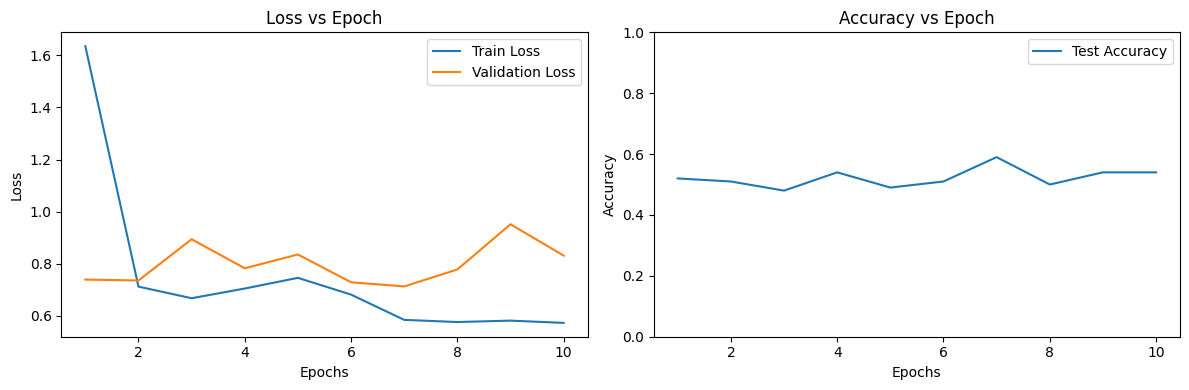

In [57]:
# Assuming you have the following lists available: train_losses, test_losses, test_accuracies, num_epochs

# Plotting loss vs accuracy, loss vs epoch, accuracy vs epoch
plt.figure(figsize=(12, 4))

# Plot Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(pt_base_epochs, pt_base_train_losses, label='Train Loss')
plt.plot(pt_base_epochs, pt_base_test_losses, label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(pt_base_epochs, pt_base_test_accuracies, label='Test Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


### 2.2 Pre-Trained InceptionV3 Model in PyTorch Framework

In [80]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # InceptionV3 requires input size of (299, 299)
    transforms.ToTensor(),
])

In [81]:
# Load the entire dataset
full_dataset = datasets.ImageFolder(root=folder_path, transform=transform)

In [82]:
# Split the dataset into train and test sets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [83]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [84]:
# Initialize the InceptionV3 model
inception_model = inception_v3(pretrained=False)

# Modify the last fully connected layer for binary classification
inception_model.fc = nn.Linear(inception_model.fc.in_features, 1)

In [85]:
# Define a loss function and an optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(inception_model.parameters(), lr=0.001)

In [86]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inception_model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [87]:
# Training loop
num_epochs = 10
pt_inception_train_losses = []
pt_inception_test_losses = []
pt_inception_test_accuracies = []
pt_inception_epochs = []

for epoch in range(num_epochs):
    inception_model.train()
    epoch_train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Access the logits from the InceptionV3 model
        outputs = inception_model(inputs)
        predictions = outputs.logits.squeeze(1) if hasattr(outputs, 'logits') else outputs.squeeze(1)
        
        loss = criterion(predictions, labels.float())
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    pt_inception_train_losses.append(epoch_train_loss)

    inception_model.eval()
    with torch.no_grad():
        correct_predictions = 0
        total_samples = 0
        test_loss = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Access the logits from the InceptionV3 model
            outputs = inception_model(inputs)
            predictions = outputs.logits.squeeze(1) if hasattr(outputs, 'logits') else outputs.squeeze(1)
            
            test_loss += criterion(predictions, labels.float()).item()
            predicted_classes = (torch.sigmoid(predictions) > 0.5).float()
            correct_predictions += (predicted_classes == labels).sum().item()
            total_samples += labels.size(0)

        test_accuracy = correct_predictions / total_samples
        pt_inception_test_losses.append(test_loss / len(test_loader))
        pt_inception_test_accuracies.append(test_accuracy)
        pt_inception_epochs.append(epoch + 1)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Test Accuracy: {test_accuracy:.4f}')


Epoch [1/10], Test Accuracy: 0.5000
Epoch [2/10], Test Accuracy: 0.5000
Epoch [3/10], Test Accuracy: 0.5200
Epoch [4/10], Test Accuracy: 0.6000
Epoch [5/10], Test Accuracy: 0.7100
Epoch [6/10], Test Accuracy: 0.6900
Epoch [7/10], Test Accuracy: 0.6200
Epoch [8/10], Test Accuracy: 0.6200
Epoch [9/10], Test Accuracy: 0.6200
Epoch [10/10], Test Accuracy: 0.6100


## Part 3: Compare Results

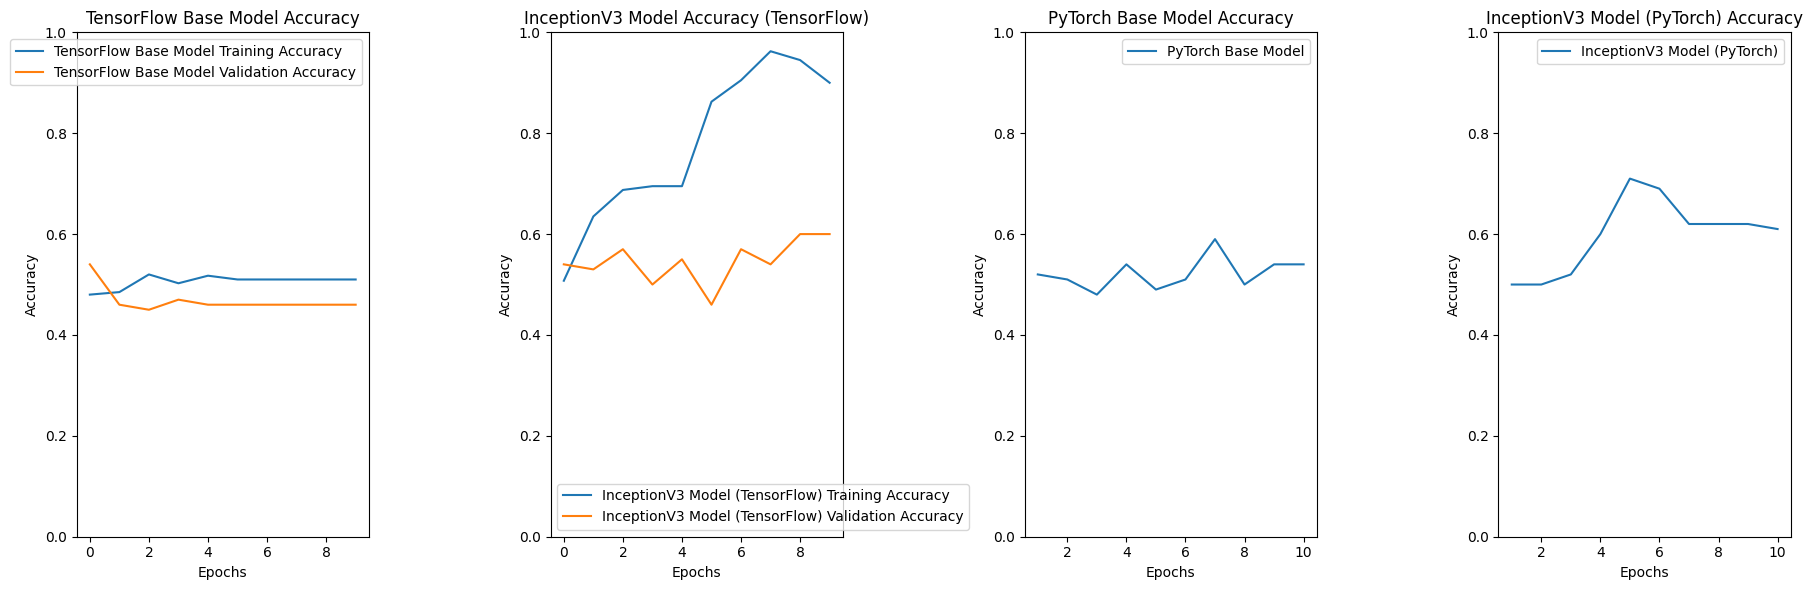

In [88]:
def plot_accuracy(history, label):
    plt.plot(history.history['accuracy'], label=f'{label} Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{label} Validation Accuracy')

# Assuming you have history objects for both models (tensorflow_history, inception_history)
plt.figure(figsize=(18, 6))

# Plot TensorFlow base model accuracy
plt.subplot(1, 4, 1)
plot_accuracy(tf_base_history, 'TensorFlow Base Model')
plt.title('TensorFlow Base Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# Plot InceptionV3 model accuracy with TensorFlow
plt.subplot(1, 4, 2)
plot_accuracy(tf_inception_history, 'InceptionV3 Model (TensorFlow)')
plt.title('InceptionV3 Model Accuracy (TensorFlow)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# Plot PyTorch base model accuracy
plt.subplot(1, 4, 3)
plt.plot(pt_base_epochs, pt_base_test_accuracies, label='PyTorch Base Model')
plt.title('PyTorch Base Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# Plot PyTorch base model accuracy
plt.subplot(1, 4, 4)
plt.plot(pt_inception_epochs, pt_inception_test_accuracies, label='InceptionV3 Model (PyTorch)')
plt.title('InceptionV3 Model (PyTorch) Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()


We were unable to record the train results for the PyTorch models to make a proper comparison with the TensorFlow models, however from these results, we find that in terms of test accuracy, the **pre-trained InceptionV3 model implemented in PyTorch provided best results, with an accuracy of about 75%**. 

Accuracy results could have been improved if we had:
- incorporated all 25,000 images in the dataset
- performed hyperparameter tuning for model parameters like epochs, batch size, learning rate, etc.
- experimented with the neural network architechture (e.g. more layers)

However, due to our system's physical constraints, we were not able to do so. Regardless, as a first foray into image classification using two neural network frameworks (TensorFlow and PyTorch), this was a great learning excerise! Keeping the limitations in mind, next steps include finding ways to bypass system hardware.